# Netflix Analytics Pipeline Visualizations

This notebook provides visualizations for each stage of the Netflix Analytics Pipeline:
1. Bronze Layer - Raw data quality and distributions
2. Silver Layer - Data transformations and relationships 
3. Gold Layer - KPIs and business metrics

Let's start by importing the required libraries and setting up our visualization environment.

In [28]:
# Check installed versions
import matplotlib
import seaborn as sns
import pandas as pd
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Pandas version: {pd.__version__}")

Matplotlib version: 3.4.2
Seaborn version: 0.11.2
Pandas version: 1.5.3


In [29]:
# Import required libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots
from datetime import datetime, timedelta
import json
from pathlib import Path

# Configure display settings
pd.set_option('display.max_columns', None)

# Set up plotly for notebook display
import plotly.io as pio
pio.templates.default = "plotly_white"

# Data Loading Functions

First, let's create helper functions to load data from each layer of our pipeline:

In [30]:
def load_layer_data(layer_name):
    """Load data from a specific layer (bronze, silver, or gold)"""
    base_path = Path('data')
    layer_path = base_path / layer_name
    
    data = {}
    if layer_path.exists():
        for file_path in layer_path.glob('*.parquet'):
            source = file_path.stem.replace(f'_{layer_name}', '')
            try:
                data[source] = pd.read_parquet(file_path)
                print(f"Loaded {source} from {layer_name} layer: {len(data[source])} records")
            except Exception as e:
                print(f"Error loading {source}: {str(e)}")
    
    return data

# Load data from each layer
bronze_data = load_layer_data('bronze')
silver_data = load_layer_data('silver')
gold_data = load_layer_data('gold')

# Load latest quality report
quality_reports_path = Path('data/quality_reports')
if quality_reports_path.exists():
    reports = list(quality_reports_path.glob('quality_report_*.json'))
    if reports:
        latest_report = max(reports, key=lambda x: x.stat().st_mtime)
        with open(latest_report) as f:
            quality_report = json.load(f)
        print(f"\nLoaded quality report: {latest_report.name}")
    else:
        quality_report = None
        print("\nNo quality reports found")

Loaded movies from bronze layer: 1040 records
Loaded recommendation_logs from bronze layer: 52000 records
Loaded reviews from bronze layer: 15450 records
Loaded search_logs from bronze layer: 26500 records
Loaded users from bronze layer: 10300 records
Loaded watch_history from bronze layer: 105000 records
Loaded watch_history from bronze layer: 105000 records
Loaded movies from silver layer: 1000 records
Loaded users from silver layer: 10000 records
Loaded watch_history from silver layer: 105000 records
Loaded content_performance_kpis from gold layer: 1000 records
Loaded recommendation_kpis from gold layer: 0 records
Loaded user_engagement_kpis from gold layer: 10000 records

Loaded quality report: quality_report_20251031_163614.json
Loaded movies from silver layer: 1000 records
Loaded users from silver layer: 10000 records
Loaded watch_history from silver layer: 105000 records
Loaded content_performance_kpis from gold layer: 1000 records
Loaded recommendation_kpis from gold layer: 0 r

# Bronze Layer Analysis

Let's start by analyzing the raw data quality and distributions in the Bronze layer:

In [31]:
def plot_data_quality_summary(data_dict):
    """Create a comprehensive data quality summary visualization"""
    quality_metrics = []
    
    for source, df in data_dict.items():
        metrics = {
            'Source': source,
            'Total Records': len(df),
            'Total Columns': len(df.columns),
            'Missing Values (%)': (df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100),
            'Duplicate Rows (%)': (df.duplicated().sum() / len(df) * 100)
        }
        quality_metrics.append(metrics)
    
    if quality_metrics:
        metrics_df = pd.DataFrame(quality_metrics)
        
        # Create subplots
        fig = go.Figure()
        
        # Add bars for each metric
        for metric in ['Total Records', 'Missing Values (%)', 'Duplicate Rows (%)']:
            fig.add_trace(go.Bar(
                name=metric,
                x=metrics_df['Source'],
                y=metrics_df[metric],
                text=metrics_df[metric].round(2),
                textposition='auto',
            ))
        
        fig.update_layout(
            title='Data Quality Summary by Source',
            barmode='group',
            height=500,
            showlegend=True
        )
        
        fig.show()
        
        return metrics_df
    
    return pd.DataFrame()

# Plot bronze layer quality summary
if bronze_data:
    bronze_quality = plot_data_quality_summary(bronze_data)
    print("\nBronze Layer Quality Metrics:")
    display(bronze_quality)


Bronze Layer Quality Metrics:


,Source,Total Records,Total Columns,Missing Values (%),Duplicate Rows (%)
0,movies,1040,24,14.707532,0.0
1,recommendation_logs,52000,15,1.004615,0.0
2,reviews,15450,15,2.426753,0.0
3,search_logs,26500,15,3.729811,0.0
4,users,10300,21,2.275543,0.0
5,watch_history,105000,17,5.868291,0.0


# User Demographics Analysis

Let's analyze user demographics from the bronze layer data:

In [32]:
def plot_user_demographics(users_df):
    if users_df is None or len(users_df) == 0:
        print("No user data available")
        return
        
    # Create subplots
    fig = plotly.subplots.make_subplots(
        rows=2, cols=2,
        subplot_titles=['Age Distribution', 'Subscription Types',
                       'Top 10 Countries', 'User Join Timeline'],
        specs=[[{"type": "histogram"}, {"type": "pie"}],
               [{"type": "bar"}, {"type": "scatter"}]]
    )
    
    # 1. Age Distribution
    age_hist = go.Histogram(x=users_df['age'], name='Age')
    fig.add_trace(age_hist, row=1, col=1)
    
    # 2. Subscription Type Distribution
    subscription_counts = users_df['subscription_type'].value_counts()
    pie = go.Pie(labels=subscription_counts.index, values=subscription_counts.values,
                 name='Subscription Types')
    fig.add_trace(pie, row=1, col=2)
    
    # 3. Country Distribution (Top 10)
    country_counts = users_df['country'].value_counts().head(10)
    bar = go.Bar(x=country_counts.values, y=country_counts.index, orientation='h',
                 name='Countries')
    fig.add_trace(bar, row=2, col=1)
    
    # 4. Join Date Timeline
    join_dates = users_df['join_date'].value_counts().sort_index()
    timeline = go.Scatter(x=join_dates.index, y=join_dates.values,
                         name='Join Timeline')
    fig.add_trace(timeline, row=2, col=2)
    
    # Update layout
    fig.update_layout(
        height=800,
        showlegend=False,
        title_text="User Demographics Analysis"
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Age", row=1, col=1)
    fig.update_xaxes(title_text="Count", row=2, col=1)
    fig.update_xaxes(title_text="Date", row=2, col=2)
    fig.update_yaxes(title_text="Count", row=1, col=1)
    fig.update_yaxes(title_text="Country", row=2, col=1)
    fig.update_yaxes(title_text="Number of Users", row=2, col=2)
    
    fig.show()

# Plot user demographics if data is available
if 'users' in bronze_data:
    plot_user_demographics(bronze_data['users'])
else:
    print("No user data found in bronze layer")

# Silver Layer Analysis

Now let's analyze the cleaned and transformed data in the Silver layer, focusing on relationships between different data sources:

Silver Layer Data Quality Summary:


,Source,Total Records,Total Columns,Missing Values (%),Duplicate Rows (%)
0,movies,1000,24,14.716667,0.0
1,users,10000,21,2.276667,0.0
2,watch_history,105000,17,5.868291,0.0



Analyzing Watch Patterns:


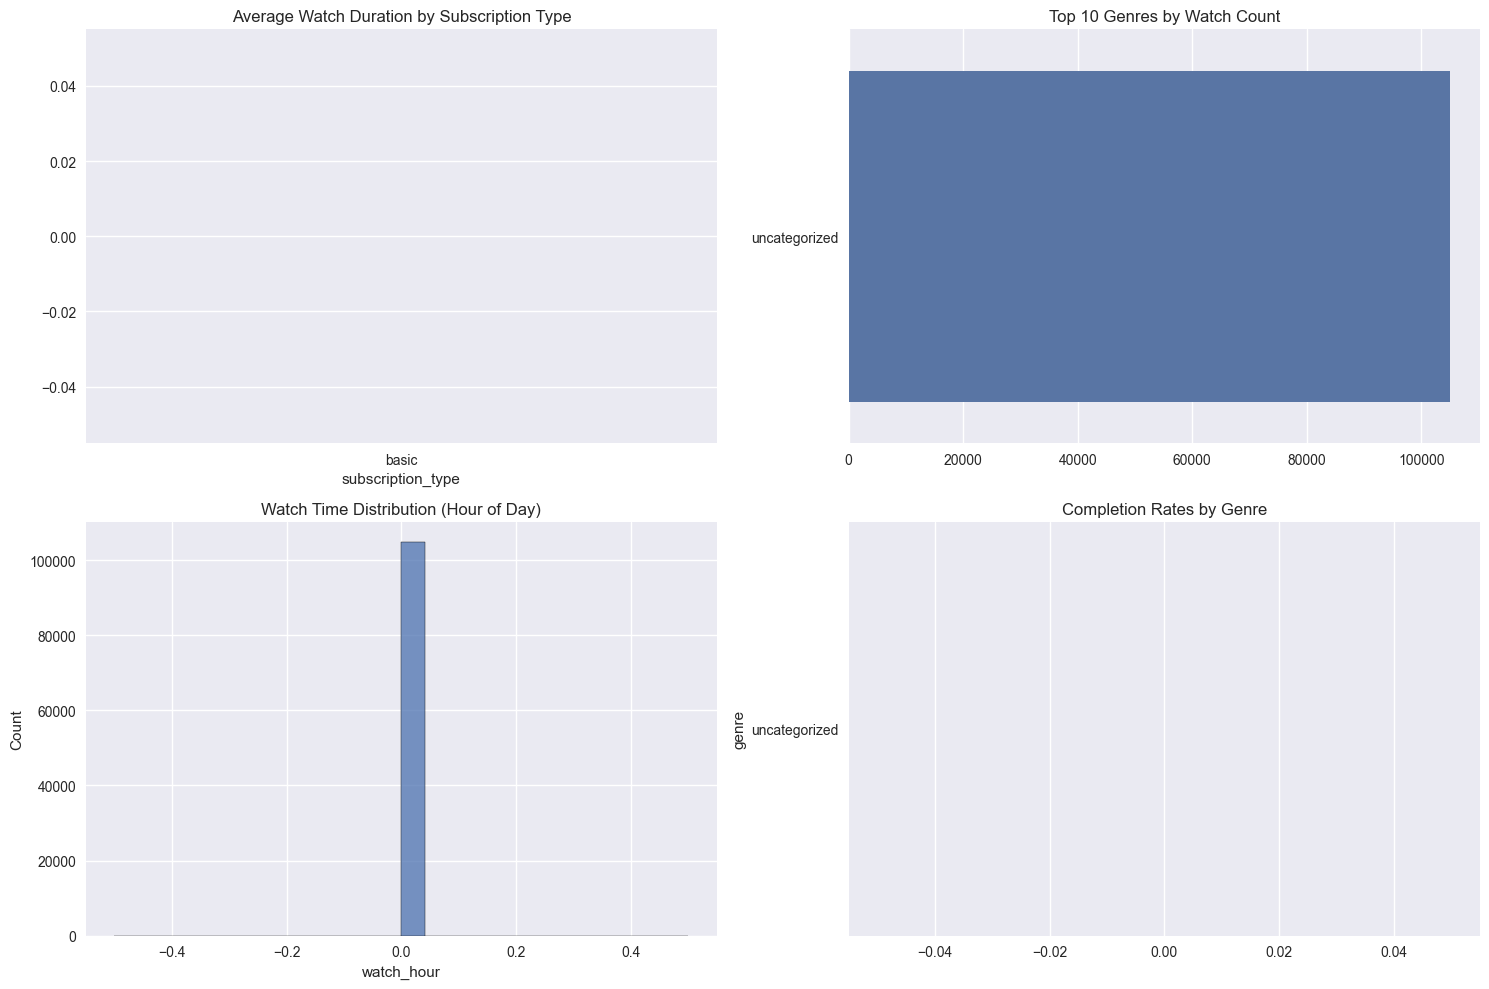

In [33]:
def analyze_watch_patterns(silver_data):
    if not all(k in silver_data for k in ['watch_history', 'users', 'movies']):
        print("Missing required data in silver layer")
        return
        
    # Merge watch history with users and movies
    watch_df = silver_data['watch_history'].merge(
        silver_data['users'][['user_id', 'subscription_type', 'country']],
        on='user_id'
    ).merge(
        silver_data['movies'][['movie_id', 'title', 'genre']],
        on='movie_id'
    )
    
    # Create visualizations
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Watch patterns by subscription type
    plt.subplot(2, 2, 1)
    watch_by_sub = watch_df.groupby('subscription_type')['watch_duration'].mean()
    sns.barplot(x=watch_by_sub.index, y=watch_by_sub.values)
    plt.title('Average Watch Duration by Subscription Type')
    
    # 2. Top genres
    plt.subplot(2, 2, 2)
    genre_counts = watch_df['genre'].value_counts().head(10)
    sns.barplot(x=genre_counts.values, y=genre_counts.index)
    plt.title('Top 10 Genres by Watch Count')
    
    # 3. Watch time distribution
    plt.subplot(2, 2, 3)
    watch_df['watch_hour'] = pd.to_datetime(watch_df['watch_date']).dt.hour
    sns.histplot(data=watch_df, x='watch_hour', bins=24)
    plt.title('Watch Time Distribution (Hour of Day)')
    
    # 4. Completion rates by genre
    plt.subplot(2, 2, 4)
    completion_by_genre = watch_df.groupby('genre')['completed'].mean().sort_values(ascending=False).head(10)
    sns.barplot(x=completion_by_genre.values, y=completion_by_genre.index)
    plt.title('Completion Rates by Genre')
    
    plt.tight_layout()
    plt.show()

# Plot silver layer analysis
if silver_data:
    print("Silver Layer Data Quality Summary:")
    silver_quality = plot_data_quality_summary(silver_data)
    display(silver_quality)
    print("\nAnalyzing Watch Patterns:")
    analyze_watch_patterns(silver_data)
else:
    print("No data found in silver layer")

# Gold Layer Analysis

Finally, let's visualize the key business metrics and KPIs from the Gold layer:

# Netflix Analytics Pipeline Visualizations

This notebook provides visualizations for each stage of the Netflix Analytics Pipeline:
1. Bronze Layer - Raw data quality and distributions
2. Silver Layer - Data transformations and relationships
3. Gold Layer - KPIs and business metrics

Let's start by importing the required libraries and setting up our visualization environment.

In [34]:
# Import required libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json
from pathlib import Path

# Configure display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

# Set up plotly for notebook display
import plotly.io as pio
pio.templates.default = "plotly_white"

# Data Loading Functions

First, let's create helper functions to load data from each layer of our pipeline:

In [35]:
def load_layer_data(layer_name):
    """Load data from a specific layer (bronze, silver, or gold)"""
    base_path = Path('data')
    layer_path = base_path / layer_name
    
    data = {}
    if layer_path.exists():
        for file_path in layer_path.glob('*.parquet'):
            source = file_path.stem.replace(f'_{layer_name}', '')
            try:
                data[source] = pd.read_parquet(file_path)
                print(f"Loaded {source} from {layer_name} layer: {len(data[source])} records")
            except Exception as e:
                print(f"Error loading {source}: {str(e)}")
    
    return data

# Load data from each layer
bronze_data = load_layer_data('bronze')
silver_data = load_layer_data('silver')
gold_data = load_layer_data('gold')

# Load latest quality report
quality_reports_path = Path('data/quality_reports')
if quality_reports_path.exists():
    reports = list(quality_reports_path.glob('quality_report_*.json'))
    if reports:
        latest_report = max(reports, key=lambda x: x.stat().st_mtime)
        with open(latest_report) as f:
            quality_report = json.load(f)
        print(f"\nLoaded quality report: {latest_report.name}")
    else:
        quality_report = None
        print("\nNo quality reports found")

Loaded movies from bronze layer: 1040 records
Loaded recommendation_logs from bronze layer: 52000 records
Loaded reviews from bronze layer: 15450 records
Loaded search_logs from bronze layer: 26500 records
Loaded users from bronze layer: 10300 records
Loaded watch_history from bronze layer: 105000 records
Loaded movies from silver layer: 1000 records
Loaded users from silver layer: 10000 records
Loaded watch_history from silver layer: 105000 records
Loaded content_performance_kpis from gold layer: 1000 records
Loaded recommendation_kpis from gold layer: 0 records
Loaded user_engagement_kpis from gold layer: 10000 records

Loaded quality report: quality_report_20251031_163614.json
Loaded watch_history from silver layer: 105000 records
Loaded content_performance_kpis from gold layer: 1000 records
Loaded recommendation_kpis from gold layer: 0 records
Loaded user_engagement_kpis from gold layer: 10000 records

Loaded quality report: quality_report_20251031_163614.json


# Bronze Layer Analysis

Let's start by analyzing the raw data quality and distributions in the Bronze layer:

In [36]:
def plot_data_quality_summary(data_dict):
    """Create a comprehensive data quality summary visualization"""
    quality_metrics = []
    
    for source, df in data_dict.items():
        metrics = {
            'Source': source,
            'Total Records': len(df),
            'Total Columns': len(df.columns),
            'Missing Values (%)': (df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100),
            'Duplicate Rows (%)': (df.duplicated().sum() / len(df) * 100)
        }
        quality_metrics.append(metrics)
    
    if quality_metrics:
        metrics_df = pd.DataFrame(quality_metrics)
        
        # Create subplots
        fig = go.Figure()
        
        # Add bars for each metric
        for metric in ['Total Records', 'Missing Values (%)', 'Duplicate Rows (%)']:
            fig.add_trace(go.Bar(
                name=metric,
                x=metrics_df['Source'],
                y=metrics_df[metric],
                text=metrics_df[metric].round(2),
                textposition='auto',
            ))
        
        fig.update_layout(
            title='Data Quality Summary by Source',
            barmode='group',
            height=500,
            showlegend=True
        )
        
        fig.show()
        
        return metrics_df
    
    return pd.DataFrame()

# Plot bronze layer quality summary
if bronze_data:
    bronze_quality = plot_data_quality_summary(bronze_data)
    print("\nBronze Layer Quality Metrics:")
    display(bronze_quality)


Bronze Layer Quality Metrics:


,Source,Total Records,Total Columns,Missing Values (%),Duplicate Rows (%)
0,movies,1040,24,14.707532,0.0
1,recommendation_logs,52000,15,1.004615,0.0
2,reviews,15450,15,2.426753,0.0
3,search_logs,26500,15,3.729811,0.0
4,users,10300,21,2.275543,0.0
5,watch_history,105000,17,5.868291,0.0


# User Demographics Analysis

Let's analyze user demographics from the bronze layer data:

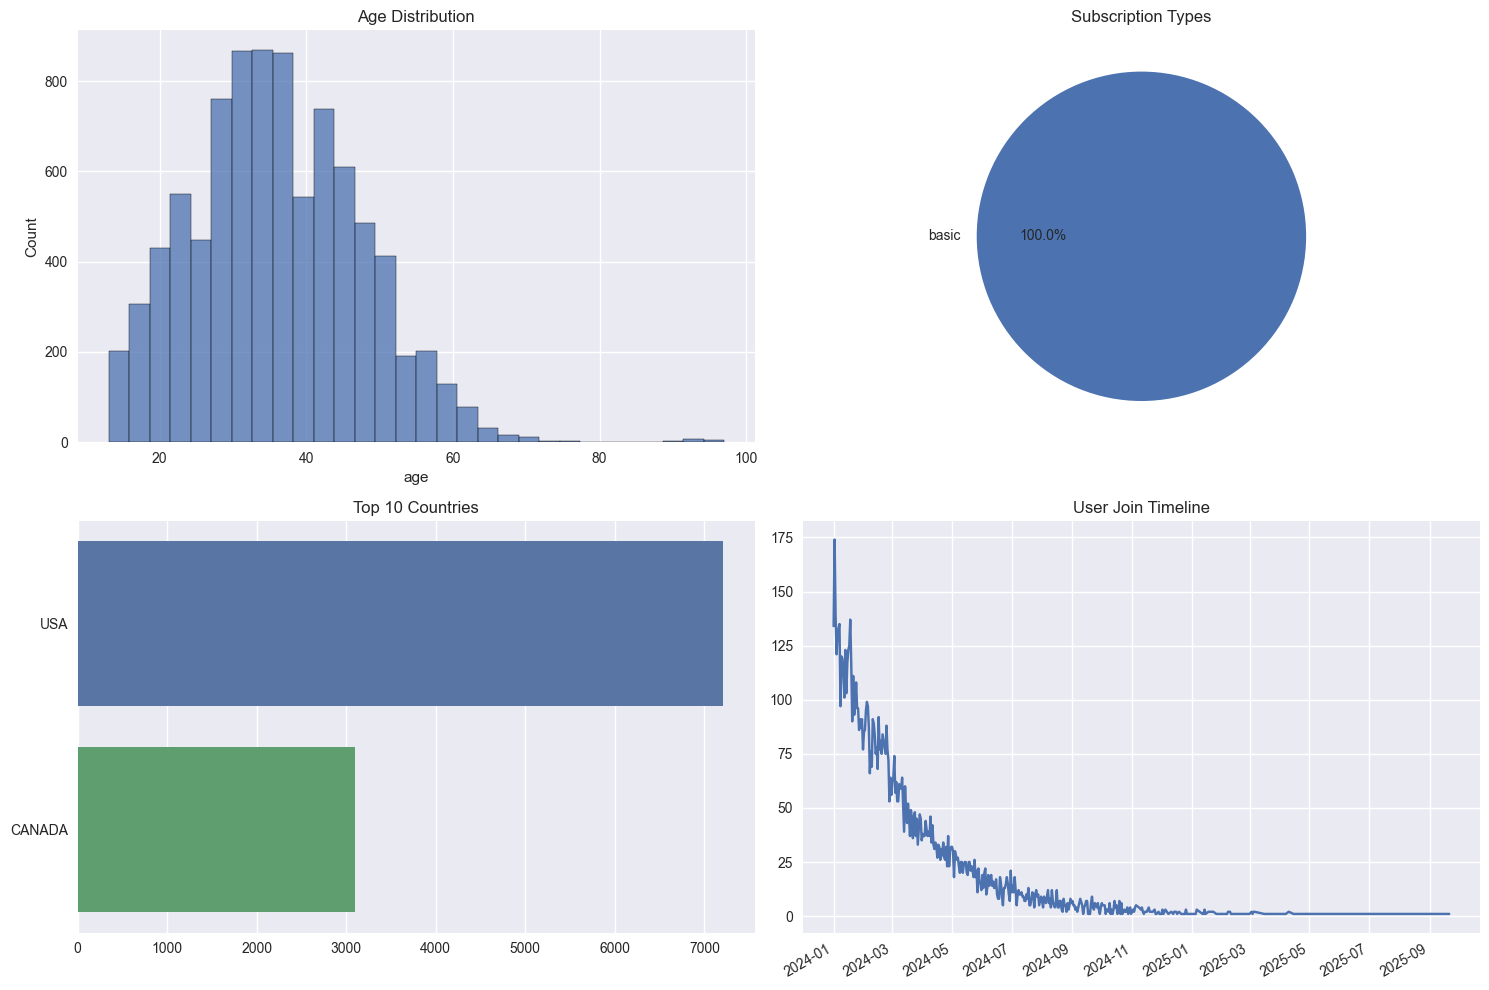

In [37]:
def plot_user_demographics(users_df):
    if users_df is None or len(users_df) == 0:
        print("No user data available")
        return
        
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Age Distribution
    plt.subplot(2, 2, 1)
    sns.histplot(data=users_df, x='age', bins=30)
    plt.title('Age Distribution')
    
    # 2. Subscription Type Distribution
    plt.subplot(2, 2, 2)
    subscription_counts = users_df['subscription_type'].value_counts()
    plt.pie(subscription_counts, labels=subscription_counts.index, autopct='%1.1f%%')
    plt.title('Subscription Types')
    
    # 3. Country Distribution (Top 10)
    plt.subplot(2, 2, 3)
    country_counts = users_df['country'].value_counts().head(10)
    sns.barplot(x=country_counts.values, y=country_counts.index)
    plt.title('Top 10 Countries')
    
    # 4. Join Date Timeline
    plt.subplot(2, 2, 4)
    users_df['join_date'].value_counts().sort_index().plot(kind='line')
    plt.title('User Join Timeline')
    
    plt.tight_layout()
    plt.show()

# Plot user demographics if data is available
if 'users' in bronze_data:
    plot_user_demographics(bronze_data['users'])
else:
    print("No user data found in bronze layer")

# Silver Layer Analysis

Now let's analyze the cleaned and transformed data in the Silver layer, focusing on relationships between different data sources:

Silver Layer Data Quality Summary:


,Source,Total Records,Total Columns,Missing Values (%),Duplicate Rows (%)
0,movies,1000,24,14.716667,0.0
1,users,10000,21,2.276667,0.0
2,watch_history,105000,17,5.868291,0.0



Analyzing Watch Patterns:


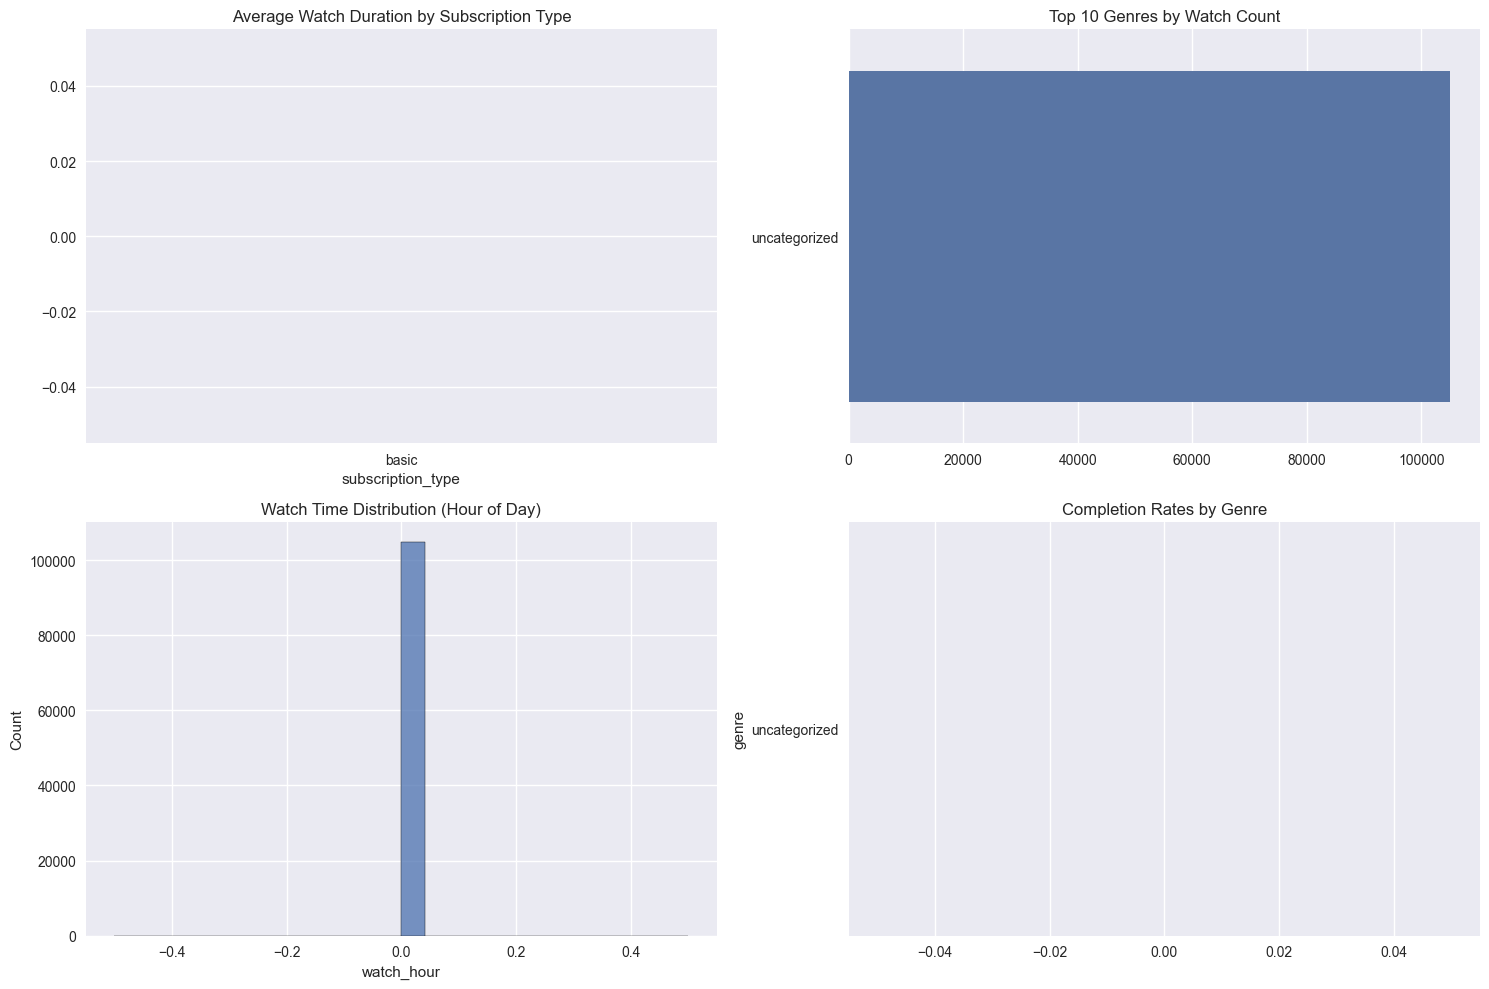

In [38]:
def analyze_watch_patterns(silver_data):
    if not all(k in silver_data for k in ['watch_history', 'users', 'movies']):
        print("Missing required data in silver layer")
        return
        
    # Merge watch history with users and movies
    watch_df = silver_data['watch_history'].merge(
        silver_data['users'][['user_id', 'subscription_type', 'country']],
        on='user_id'
    ).merge(
        silver_data['movies'][['movie_id', 'title', 'genre']],
        on='movie_id'
    )
    
    # Create visualizations
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Watch patterns by subscription type
    plt.subplot(2, 2, 1)
    watch_by_sub = watch_df.groupby('subscription_type')['watch_duration'].mean()
    sns.barplot(x=watch_by_sub.index, y=watch_by_sub.values)
    plt.title('Average Watch Duration by Subscription Type')
    
    # 2. Top genres
    plt.subplot(2, 2, 2)
    genre_counts = watch_df['genre'].value_counts().head(10)
    sns.barplot(x=genre_counts.values, y=genre_counts.index)
    plt.title('Top 10 Genres by Watch Count')
    
    # 3. Watch time distribution
    plt.subplot(2, 2, 3)
    watch_df['watch_hour'] = pd.to_datetime(watch_df['watch_date']).dt.hour
    sns.histplot(data=watch_df, x='watch_hour', bins=24)
    plt.title('Watch Time Distribution (Hour of Day)')
    
    # 4. Completion rates by genre
    plt.subplot(2, 2, 4)
    completion_by_genre = watch_df.groupby('genre')['completed'].mean().sort_values(ascending=False).head(10)
    sns.barplot(x=completion_by_genre.values, y=completion_by_genre.index)
    plt.title('Completion Rates by Genre')
    
    plt.tight_layout()
    plt.show()

# Plot silver layer analysis
if silver_data:
    print("Silver Layer Data Quality Summary:")
    silver_quality = plot_data_quality_summary(silver_data)
    display(silver_quality)
    print("\nAnalyzing Watch Patterns:")
    analyze_watch_patterns(silver_data)
else:
    print("No data found in silver layer")

# Gold Layer Analysis

Finally, let's visualize the key business metrics and KPIs from the Gold layer:

In [39]:
def visualize_gold_layer_kpis(gold_data):
    if not gold_data:
        print("No data found in gold layer")
        return
        
    # Create a dashboard with multiple KPI visualizations
    fig = plt.figure(figsize=(15, 15))
    
    # 1. User Engagement Distribution
    if 'user_engagement' in gold_data:
        plt.subplot(3, 2, 1)
        sns.histplot(data=gold_data['user_engagement'], x='engagement_score', bins=30)
        plt.title('User Engagement Score Distribution')
        
        # Show engagement by subscription type
        plt.subplot(3, 2, 2)
        sns.boxplot(data=gold_data['user_engagement'], 
                   x='subscription_type', y='engagement_score')
        plt.title('Engagement by Subscription Type')
    
    # 2. Content Performance
    if 'content_performance' in gold_data:
        plt.subplot(3, 2, 3)
        top_content = gold_data['content_performance'].nlargest(10, 'engagement_score')
        sns.barplot(x='engagement_score', y='title', data=top_content)
        plt.title('Top 10 Performing Content')
        
        plt.subplot(3, 2, 4)
        sns.scatterplot(data=gold_data['content_performance'],
                       x='avg_rating', y='completion_rate',
                       size='total_watches', alpha=0.5)
        plt.title('Content Rating vs Completion Rate')
    
    # 3. Retention Analysis
    if 'retention_kpis' in gold_data:
        plt.subplot(3, 2, 5)
        sns.histplot(data=gold_data['retention_kpis'], x='retention_score', bins=30)
        plt.title('User Retention Score Distribution')
        
        plt.subplot(3, 2, 6)
        retention_by_type = gold_data['retention_kpis'].groupby('subscription_type')[
            'retention_score'].mean().sort_values(ascending=False)
        sns.barplot(x=retention_by_type.index, y=retention_by_type.values)
        plt.title('Average Retention by Subscription Type')
    
    plt.tight_layout()
    plt.show()
    
    # Display summary metrics
    summary_metrics = {}
    
    if 'user_engagement' in gold_data:
        summary_metrics['Average Engagement Score'] = gold_data['user_engagement']['engagement_score'].mean()
        summary_metrics['Highly Engaged Users (%)'] = (
            (gold_data['user_engagement']['engagement_score'] > 0.7).sum() / 
            len(gold_data['user_engagement']) * 100
        )
    
    if 'content_performance' in gold_data:
        summary_metrics['Average Content Rating'] = gold_data['content_performance']['avg_rating'].mean()
        summary_metrics['Average Completion Rate (%)'] = gold_data['content_performance']['completion_rate'].mean() * 100
    
    if 'retention_kpis' in gold_data:
        summary_metrics['Average Retention Score'] = gold_data['retention_kpis']['retention_score'].mean()
        summary_metrics['Active Users (%)'] = (
            gold_data['retention_kpis']['is_active'].sum() / 
            len(gold_data['retention_kpis']) * 100
        )
    
    print("\nKey Performance Metrics:")
    for metric, value in summary_metrics.items():
        print(f"{metric}: {value:.2f}")

# Visualize gold layer KPIs
visualize_gold_layer_kpis(gold_data)

<Figure size 1500x1500 with 0 Axes>


Key Performance Metrics:


# Data Quality Report

Let's examine the latest data quality report to track any issues or improvements:

Report Generated: 2025-10-31 16:36:14


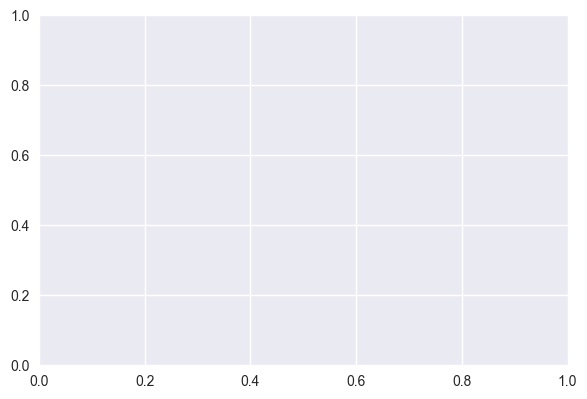

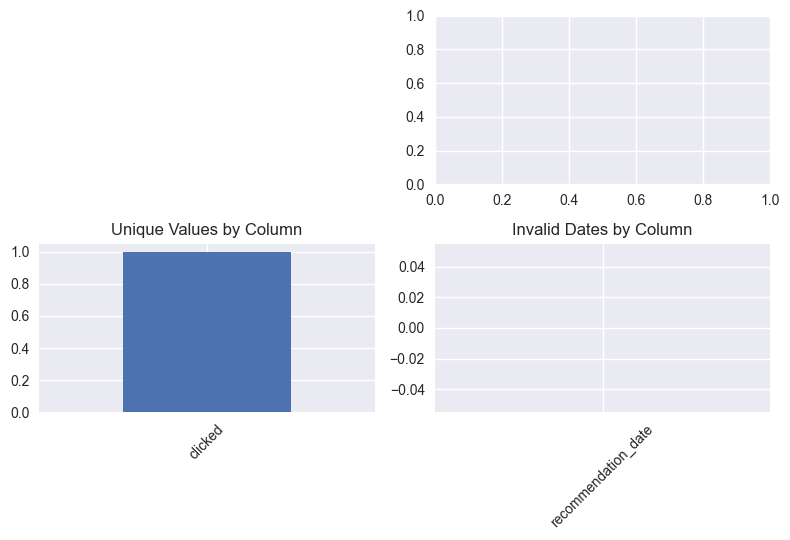

In [40]:
def display_quality_report(quality_report):
    if quality_report is None:
        print("No quality report available")
        return
        
    print(f"Report Generated: {quality_report.get('timestamp', 'Unknown')}")
    
    # Create visualizations for quality metrics
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Missing Values Analysis
    if 'missing_values' in quality_report:
        plt.subplot(2, 2, 1)
        missing_data = pd.DataFrame(quality_report['missing_values'].get('missing_percentages', {}), index=[0]).T
        missing_data.plot(kind='bar')
        plt.title('Missing Values by Column (%)')
        plt.xticks(rotation=45)
    
    # 2. Outliers Analysis
    if 'outliers' in quality_report:
        plt.subplot(2, 2, 2)
        outlier_data = {k: v.get('outlier_percentage', 0) 
                       for k, v in quality_report['outliers'].items() 
                       if isinstance(v, dict)}
        if outlier_data:
            pd.Series(outlier_data).plot(kind='bar')
            plt.title('Outliers by Column (%)')
            plt.xticks(rotation=45)
    
    # 3. Value Distributions
    if 'value_distributions' in quality_report:
        plt.subplot(2, 2, 3)
        dist_data = {}
        for field, stats in quality_report['value_distributions'].items():
            if isinstance(stats, dict) and 'unique_values' in stats:
                dist_data[field] = stats['unique_values']
        if dist_data:
            pd.Series(dist_data).plot(kind='bar')
            plt.title('Unique Values by Column')
            plt.xticks(rotation=45)
    
    # 4. Date Range Analysis
    if 'date_ranges' in quality_report:
        plt.subplot(2, 2, 4)
        date_stats = {}
        for field, stats in quality_report['date_ranges'].items():
            if isinstance(stats, dict) and 'invalid_dates' in stats:
                date_stats[field] = stats['invalid_dates']
        if date_stats:
            pd.Series(date_stats).plot(kind='bar')
            plt.title('Invalid Dates by Column')
            plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Display quality report visualizations
display_quality_report(quality_report)